# RISEI Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import show_metrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'viridis'

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
import tensorflow as tf

RANDOM_SEED = 250398
tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [4]:
import ipyparams
import datetime

NOTEBOOK_KEY = ipyparams.notebook_name.replace('.ipynb', '')
if not isinstance(NOTEBOOK_KEY, str) or not len(NOTEBOOK_KEY):
    NOTEBOOK_KEY = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
NOTEBOOK_KEY

<IPython.core.display.Javascript object>

'20201221-211636'

In [5]:
%%time

ROOT_DIR = '../../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weightss (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../../tmp\logs\20201221-211636
Wall time: 5 ms


In [6]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = '3DResNet18'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
#     'l2_beta': 0.0001,
#     'l2_beta': None,
    'dropout': 0.5,
    'blocks': (2, 2, 2),
    'filters': (64, 128, 256),
#     'dropout': None,
    'output_bias': initial_bias,
#     'output_bias': None,
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00025,
    'decay_steps': 10,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 200,
    'patience': 30,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0.2, 0.015),
        'shear': (0, 2.5), # probability, degrees
        'blur': (0.2, 0.8),
        'noise': (0.2, 0.00025)
    },
#     'augmentations': False,
    'batch_size': 12,
#     'model_checkpoint_callback': False,
}

## Model

In [7]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_res_net (MyResNet)        (None, 256)               8323712   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 8,356,866
Trainable params: 8,352,386
Non-trainable params: 4,480
_________________________________________________________________


In [8]:
load_checkpoint(model, DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL, 'ResNetCustom_v9', 'cp-0088.ckpt')

loading checkpoint from ../../../tmp\bckp-checkpoints\ResNetCustom_v9\cp-0088.ckpt...


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.7936507936507936
recall: 0.8064516129032258
f1-score: 0.7999999999999999
support: 62


CN
precision: 0.6756756756756757
recall: 0.6578947368421053
f1-score: 0.6666666666666667
support: 38


micro avg
precision: 0.75
recall: 0.75
f1-score: 0.75
support: 100


macro avg
precision: 0.7346632346632347
recall: 0.7321731748726655
f1-score: 0.7333333333333334
support: 100


weighted avg
precision: 0.7488202488202488
recall: 0.75
f1-score: 0.7493333333333334
support: 100


samples avg
precision: 0.75
recall: 0.75
f1-score: 0.75
support: 100


F1
micro: 0.75
macro: 0.7333333333333334


accuracy_score: 0.75
sensitivity_score: 0.8064516129032258
specificity_score: 0.6578947368421053


Wall time: 24.9 s


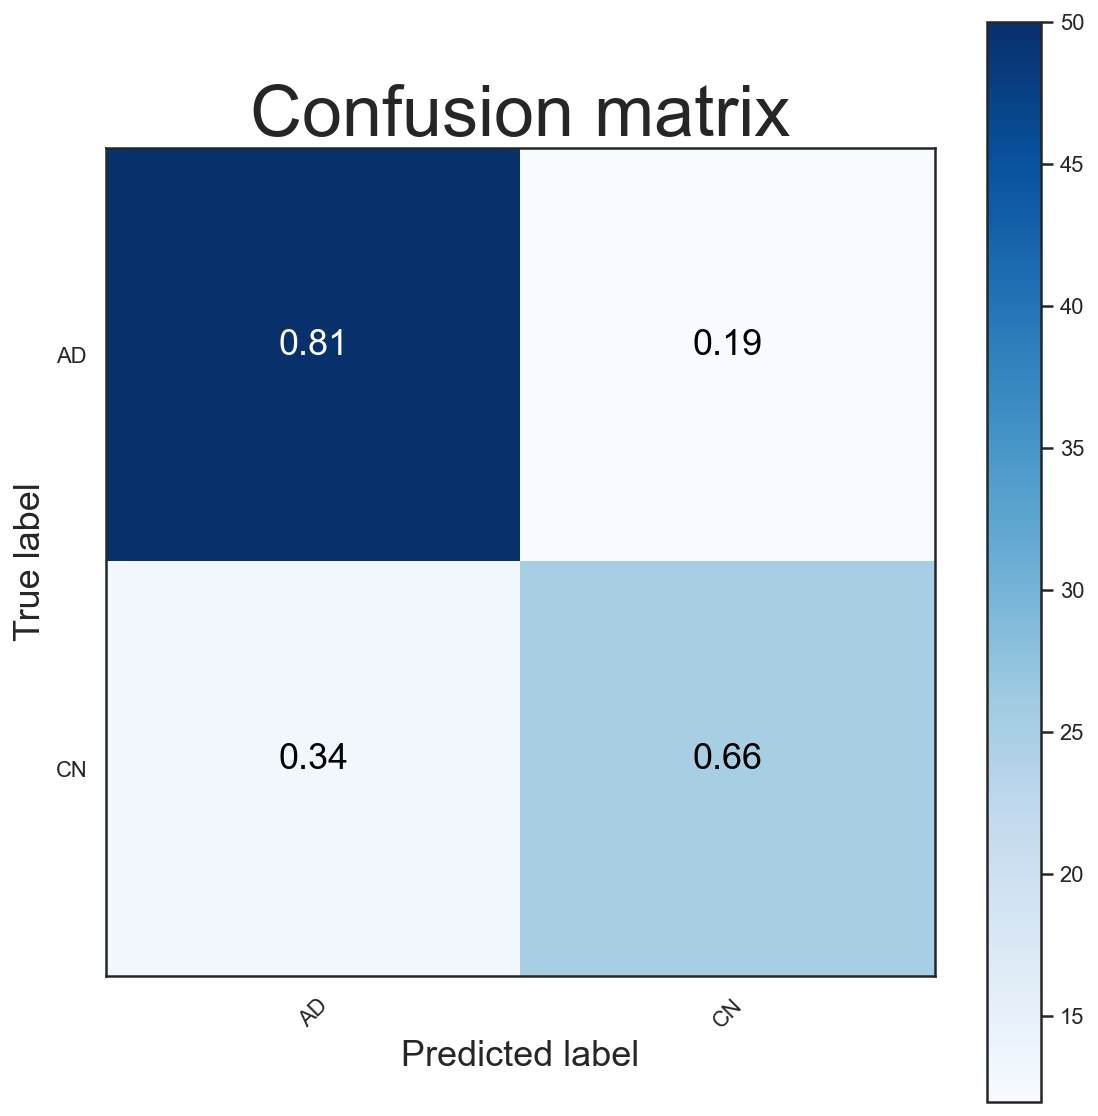

In [9]:
%%time

show_metrics(model, test_seq, class_names)

## RISEI

In [10]:
import SimpleITK as sitk

import src.heatmaps as heatmaps
import src.data.plot_image as plot_image

from src.heatmaps.evaluation import EvaluationSequence, plot_evaluation, predict_sequence_as_numpy

from src.risei import RISEI

### Config

In [11]:
risei_config = {
    's': 8, 
    'p1': 1/3, 
    'b1': 1,
    'b2': 0.25,
    'in_paint': '2d', 
    'in_paint_blending': True, 
    'in_paint_radius': 5,
    'in_paint_2d_to_3d': True,
    'processes': 4, 
}

heatmap_evaluation_config = {
    'batch_size': train_config['batch_size'],
    'masks_count': 1000,
    'evaluation_step_size': 1000,
    'evaluation_max_steps': -1,
    'risei_batch_size': 480,
    'evaluation_batch_size': 32,
}

### Generate Sample

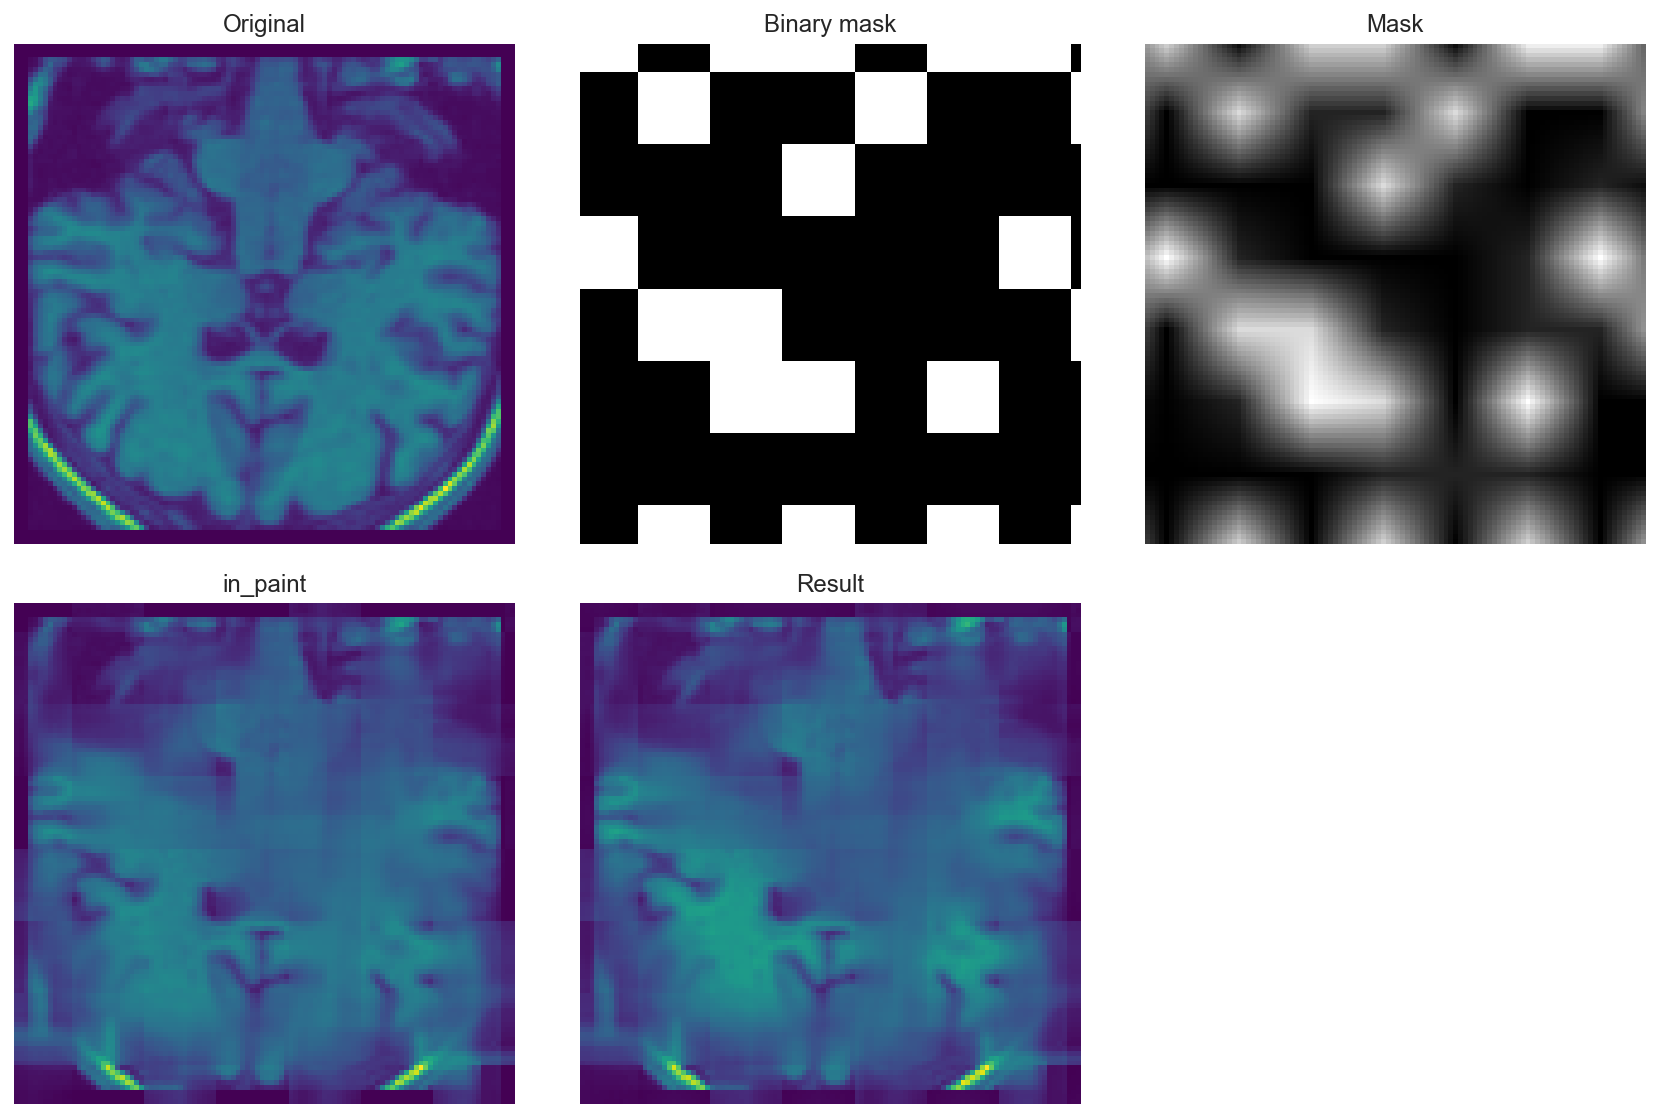

In [12]:
image_x, image_y = None, None
batch_x, batch_y, *_ = train_seq[0]
idx = 2
image_x, image_y = batch_x[idx], batch_y[idx]

risei = RISEI(image_x.shape[:-1], debug=True, **risei_config)

_ = risei.generate_masks(1, image_x.reshape(image_x.shape[:-1]), seed=420, log=False)

risei.show_from_last_run(0, 56, dim=1)

### Evaluate

In [13]:
from src.heatmaps.evaluation import HeatmapEvaluation

risei = RISEI(image_x.shape[:-1], debug=False, **risei_config)
he = HeatmapEvaluation(risei, model, test_seq, **heatmap_evaluation_config)

In [14]:
%%time

history = he.evaluate('insertion', log=True, verbose=1, seed=420, max_evaluations=25)

sequence len: 100, method: insertion
evaluation 1/100
get heatmap (masks: 1000)...
...finished in 0:18:56s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:36
auc: 5644.283019355498 (0:19:33s)

evaluation 2/100
get heatmap (masks: 1000)...
...finished in 0:18:42s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:37
auc: 1285744.6971833706 (0:19:20s)

evaluation 3/100
get heatmap (masks: 1000)...
...finished in 0:18:29s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:38
auc: 18696.131527074613 (0:19:07s)

evaluation 4/100
get heatmap (masks: 1000)...
...finished in 0:18:23s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:38
auc: 40143.03426357219 (0:19:01s)

evaluation 5/100
get heatmap (masks: 1000)...
...finished in 0:18:28s
evaluate heatmaps (voxels: 1385000, step_size: 1000, max_steps: -1)...
...finished in 0:00:37
a

evaluated heatmaps: 25
auc
	mean:     668,010.2073634672
	median:  150,931.95128248772
	max:    1,382,604.5688986778
	min:      5,644.283019355498
	std:      638,989.4462262186


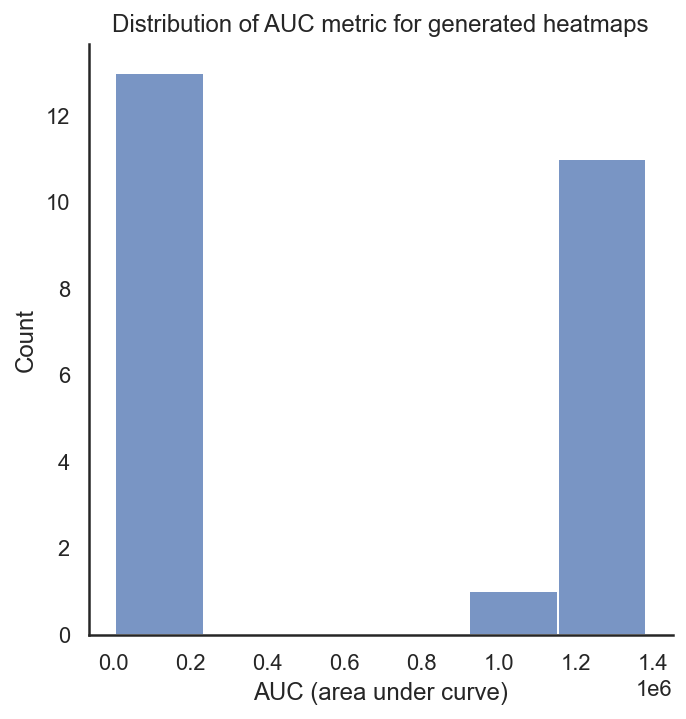

In [15]:
history.description()
history.plot_auc()

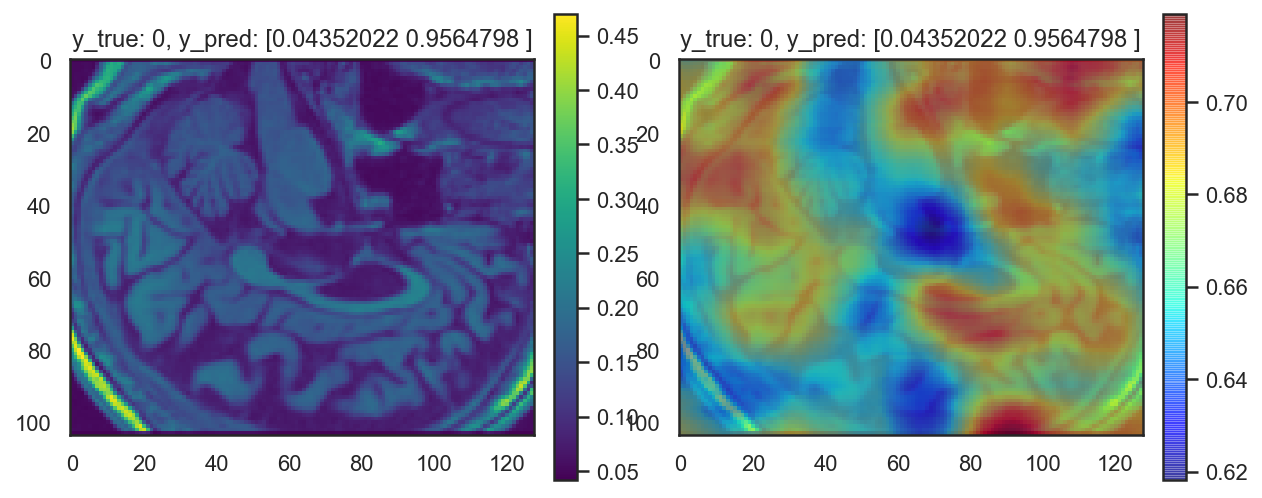

In [16]:
history.plot_heatmap_x(0)

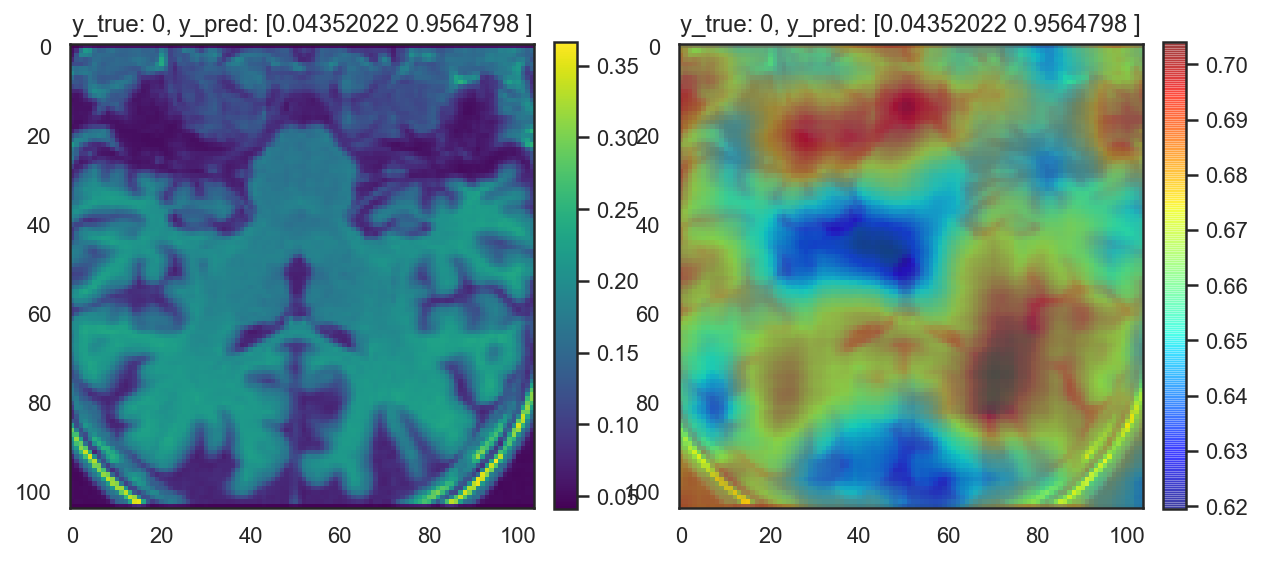

In [17]:
history.plot_heatmap_y(0)

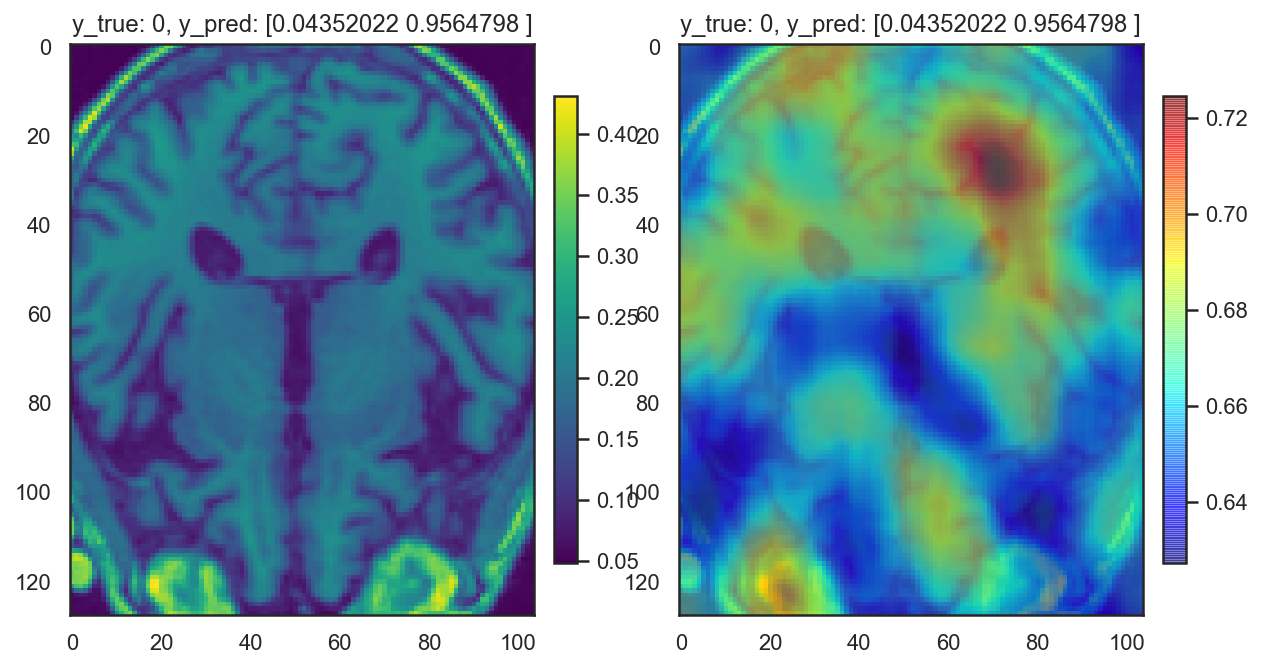

In [18]:
history.plot_heatmap_z(0)

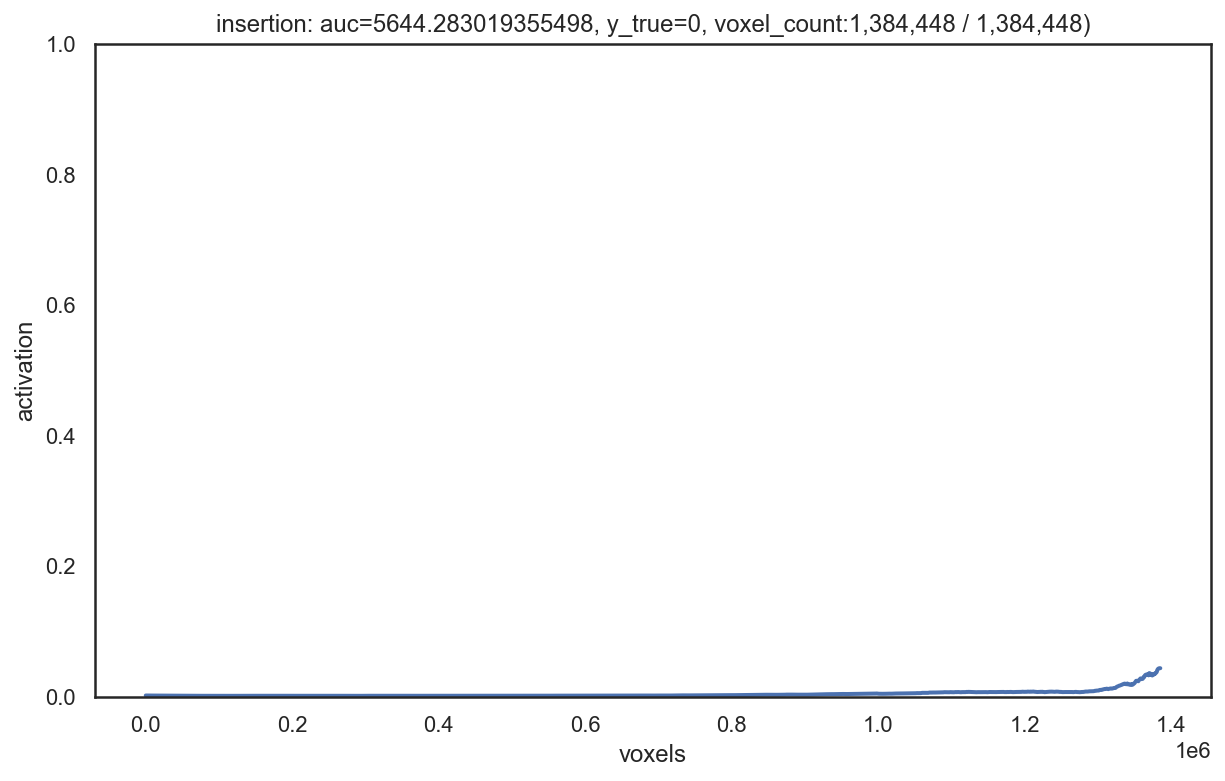

In [19]:
history.plot_evaluation(0)

In [20]:
history.save(os.path.join(ROOT_DIR, 'risei-history'), NOTEBOOK_KEY)

saved to: ../../../tmp\risei-history\20201221-211636.cls
